In [1]:
%matplotlib inline


from src.utils import create_plots, model_comparasion, is_pareto_efficient
from src.load_results import model_selection_parallel as model_selection

In [2]:
# results dir and methods
import os
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils import DTO
import numpy as np

In [3]:
def retrive_results(
    dataset,
    log_dir="results"
):
    log_dir = Path(log_dir)
    results = {}
    for root, dirs, files in os.walk(log_dir):
        for file in files:
            if file.startswith(dataset):
                pre_len = len(dataset)+len(str(log_dir))+2
                file_path = os.path.join(root, file)
                mehtod = str(os.path.join(root, file))[pre_len:-7]
                results[mehtod] = pd.read_pickle(file_path)
    return results


In [6]:
def final_results_df(
    results_dict,
    model_order = None,
    GAP_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    pareto = True,
    pareto_selection = "test",
    selection_criterion = "DTO",
    return_dev = True
    ):

    df_list = []
    for key in (results_dict.keys() if model_order is None else model_order):
        _df = results_dict[key]

        _df = _df.groupby(_df.index).agg(["mean", "std"]).reset_index()

        _df.columns = [' '.join(col).strip() for col in _df.columns.values]

        if pareto:
            _pareto_flag = is_pareto_efficient(
                -1*_df[["{}_{} mean".format(pareto_selection, GAP_metric_name), "{}_{} mean".format(pareto_selection, Performance_metric_name)]].to_numpy()
                )
            _pareto_df = _df[_pareto_flag].copy()
        else:
            _pareto_df = _df.copy()

        
        _pareto_df = _pareto_df[["{}_{} {}".format(phase, metric, value) for phase in ["test", "dev"] for metric in [Performance_metric_name, GAP_metric_name] for value in ["mean", "std"]]].copy()
        _pareto_df["Models"] = [key]*len(_pareto_df)

        _final_DTO = DTO(
            fairness_metric=list(_pareto_df["dev_{} mean".format(GAP_metric_name)]), 
            performacne_metric=list(_pareto_df["dev_{} mean".format(Performance_metric_name)])
            )
        _pareto_df["dev_DTO mean"] = _final_DTO

        if selection_criterion is not None:
            if selection_criterion == "DTO":
                selected_epoch_id = np.argmin(_pareto_df["dev_{} mean".format(selection_criterion)])
            else:
                selected_epoch_id = np.argmax(_pareto_df["dev_{} mean".format(selection_criterion)])
            _pareto_df = _pareto_df.iloc[[selected_epoch_id]].copy()
        
        df_list.append(_pareto_df)

    final_df = pd.concat(df_list)
    final_df.reset_index(inplace=True)

    if selection_criterion is not None:
        _over_DTO = DTO(
            fairness_metric=list(final_df["test_{} mean".format(GAP_metric_name)]), 
            performacne_metric=list(final_df["test_{} mean".format(Performance_metric_name)])
            )
        final_df["DTO"] = _over_DTO

        final_df = final_df[["Models"]+list(final_df.keys())[1:(9 if return_dev else 5)]+["DTO"]].copy()

    return final_df

In [22]:
def make_plot(plot_df):
    plot_df["EO Fairness"] = plot_df["test_{} mean".format("rms_TPR")]
    plot_df["Accuracy"] = plot_df["test_{} mean".format("accuracy")]

    figure = plt.figure(figsize=(6, 6), dpi = 150) 
    with sns.axes_style("white"):
        sns.lineplot(
            data=plot_df,
            x="Accuracy",
            y="EO Fairness",
            hue="Models",
            markers=True,
            style="Models",
        )

In [23]:
Moji_results = retrive_results("Moji")
Moji_results["FairBatch"] = Moji_results["OldFairBatch"]

In [24]:
Moji_main_results = final_results_df(
    results_dict = Moji_results,
    model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "GatedAdv", "GatedDAdv"],
    GAP_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    pareto = True,
    pareto_selection = "test",
    selection_criterion = "DTO",
    return_dev = True
    )
Moji_main_results

,Models,test_accuracy mean,test_accuracy std,test_rms_TPR mean,test_rms_TPR std,dev_accuracy mean,dev_accuracy std,dev_rms_TPR mean,dev_rms_TPR std,DTO
0,Vanilla,0.722981,0.004576,0.611870,0.014356,0.726650,0.003673,0.632302,0.013370,0.364045
1,Adv,0.751538,0.009777,0.910219,0.016036,0.742250,0.009617,0.925246,0.016122,0.050994
2,DAdv,0.744361,0.008597,0.925449,0.024698,0.736050,0.007867,0.926679,0.011332,0.036391
3,INLP,0.734559,NaN,0.853738,NaN,0.726250,NaN,0.860852,NaN,0.112181
4,FairBatch,0.750638,0.006012,0.905537,0.005046,0.744525,0.004995,0.917734,0.004761,0.055888
5,GatedAdv,0.739085,0.005114,0.933813,0.008281,0.731275,0.003664,0.942501,0.009297,0.031165
6,GatedDAdv,0.723556,0.009952,0.959129,0.015552,0.718175,0.009136,0.971506,0.009782,0.037233


In [25]:
Moji_plot_df = final_results_df(
    results_dict = Moji_results,
    model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "GatedAdv", "GatedDAdv"],
    GAP_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    pareto = True,
    pareto_selection = "test",
    selection_criterion = None,
    return_dev = True
    )
Moji_plot_df

,index,test_accuracy mean,test_accuracy std,test_rms_TPR mean,test_rms_TPR std,dev_accuracy mean,dev_accuracy std,dev_rms_TPR mean,dev_rms_TPR std,Models,dev_DTO mean
0,0,0.722981,0.004576,0.611870,0.014356,0.726650,0.003673,0.632302,0.013370,Vanilla,0.000000
1,31,0.756414,0.007271,0.893286,0.005623,0.747425,0.004549,0.912125,0.008507,Adv,0.070322
2,32,0.752063,0.005902,0.907539,0.009727,0.745775,0.005636,0.916974,0.011534,Adv,0.065417
3,33,0.751538,0.009777,0.910219,0.016036,0.742250,0.009617,0.925246,0.016122,Adv,0.057368
4,35,0.744886,0.013777,0.917136,0.017954,0.736425,0.013615,0.918121,0.010558,Adv,0.065875
...,...,...,...,...,...,...,...,...,...,...,...
102,397,0.588047,0.120222,0.969623,0.040655,0.584675,0.114761,0.976239,0.029626,GatedDAdv,0.225027
103,404,0.579845,0.076264,0.972860,0.029172,0.576025,0.072689,0.978131,0.021842,GatedDAdv,0.236321
104,412,0.533658,0.073046,0.989707,0.018302,0.532675,0.071054,0.995009,0.007711,GatedDAdv,0.293230
105,413,0.585021,0.051133,0.971307,0.013316,0.581125,0.047121,0.981262,0.008475,GatedDAdv,0.229361


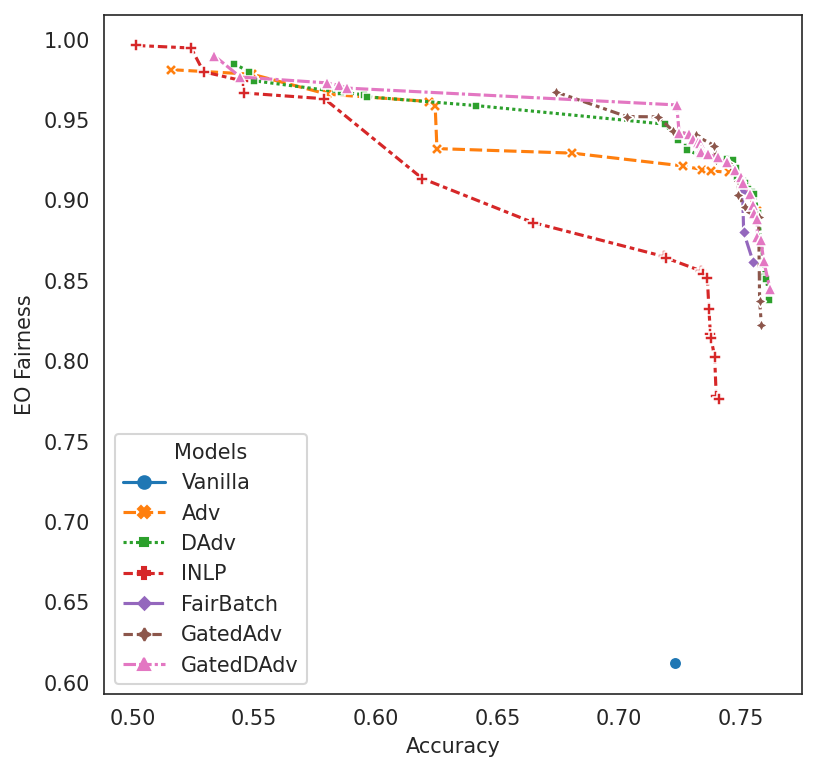

In [26]:
make_plot(Moji_plot_df)

In [27]:
Bios_both_results = retrive_results("Bios_both")

In [28]:
Bios_both_results["FairBatch"] = Bios_both_results["OldFairBatch"]
Bios_both_results["GatedAdv"] = pd.concat([Bios_both_results["GAdv"], Bios_both_results["BTGAdv"]])
Bios_both_results["GatedDAdv"] = pd.concat([Bios_both_results["GDAdv"], Bios_both_results["BTGDAdv"]])

In [29]:
Bios_both_main_results = final_results_df(
    results_dict = Bios_both_results,
    model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "GatedAdv", "GatedDAdv"],
    GAP_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    pareto = True,
    pareto_selection = "test",
    selection_criterion = "DTO",
    return_dev = True
    )
Bios_both_main_results

,Models,test_accuracy mean,test_accuracy std,test_rms_TPR mean,test_rms_TPR std,dev_accuracy mean,dev_accuracy std,dev_rms_TPR mean,dev_rms_TPR std,DTO
0,Vanilla,0.815181,0.002435,0.555411,0.029533,0.807466,0.002962,0.540741,0.011691,0.303250
1,Adv,0.674173,0.046765,0.796983,0.091443,0.669770,0.046314,0.744954,0.073168,0.172977
2,DAdv,0.680895,0.054854,0.794713,0.067696,0.675794,0.054582,0.754632,0.066709,0.164760
3,INLP,0.537539,NaN,0.749798,NaN,0.538335,NaN,0.744230,NaN,0.345729
4,FairBatch,0.812416,0.001241,0.623468,0.018890,0.805002,0.001388,0.578378,0.014323,0.217900
5,GatedAdv,0.698492,0.035838,0.792417,0.059961,0.692470,0.036704,0.744349,0.035828,0.143268
6,GatedDAdv,0.699038,0.019692,0.797145,0.047948,0.693967,0.020421,0.741946,0.034637,0.142475


In [32]:
Bios_both_plot_df = final_results_df(
    results_dict = Bios_both_results,
    model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "GatedAdv", "GatedDAdv"],
    GAP_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    pareto = True,
    pareto_selection = "test",
    selection_criterion = None,
    return_dev = True
    )

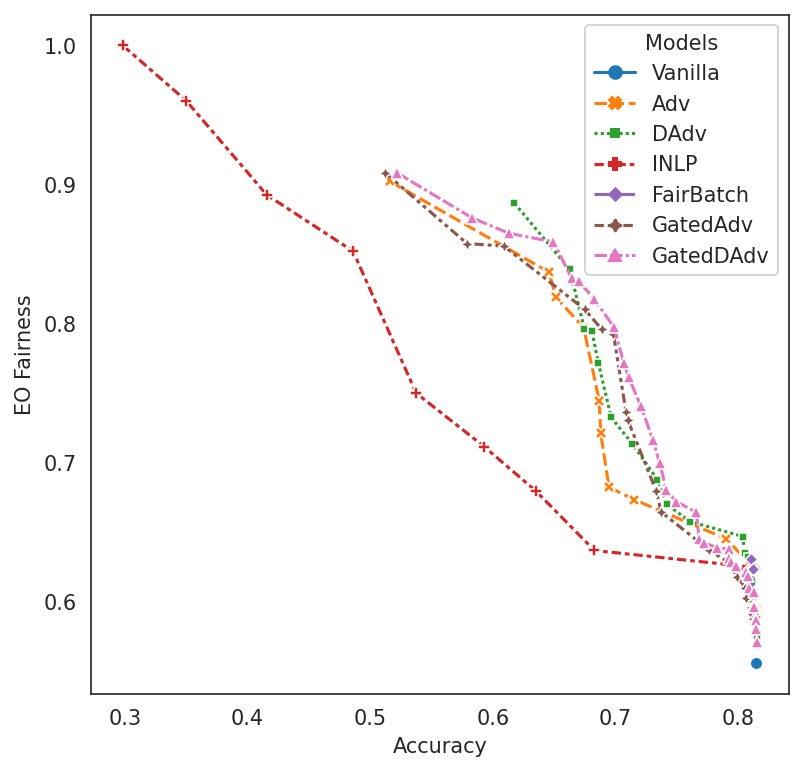

In [33]:
make_plot(Bios_both_plot_df)